# AML assignment Problem 1

# Team members:
- NANDINI JAISWAL - `MDS202335`
- ARITRA - `MCS202304` 

# Import necessary modules

In [24]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Use GPU if available

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data downloading and preprocessing

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Data insights

In [33]:
print(f'total number of images in training set: {len(train_data.targets)}')

total number of images in training set: 60000


In [5]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Function to Relabel the dataset
Congregate the images into the following categories:
- Clothes
- Shoes
- Others

In [28]:
def group_labels(label):
    """
    Relabel using following rule
     'T-shirt/top': Clothes
     'Trouser': Clothes
     'Pullover': Clothes
     'Dress': Clothes
     'Coat': Clothes
     'Sandal': Shoes
     'Shirt': Clothes
     'Sneaker': Shoes
     'Bag': Others
     'Ankle boot': Shoes
    """
    if label in [0, 1, 2, 3, 4, 6]:
        return 0
    elif label in [5, 7, 9]:
        return 1
    else:
        return 2

# Load the relabeled data

In [29]:
train_data.targets = torch.tensor([group_labels(label) for label in train_data.targets])
test_data.targets = torch.tensor([group_labels(label) for label in test_data.targets])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Print some of the relabeled data

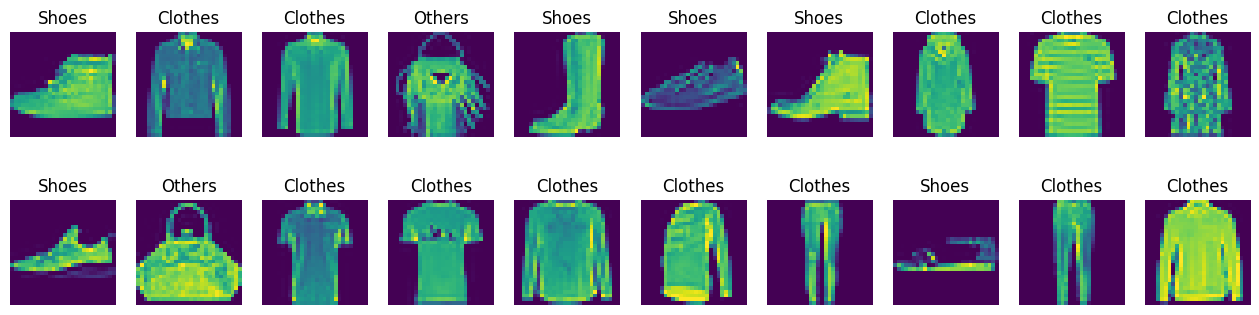

In [9]:
# Dictionary to map label numbers to class names
label_names = {
    0: 'Clothes',
    1: 'Shoes',
    2: 'Others'
}

plt.figure(figsize=(16, 4))
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    
    plt.subplot(2, 10, i + 1)
    
    # Permute for correct channel order (C, H, W) -> (H, W, C)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    
    plt.title(label_names.get(label, 'Unknown'))

plt.show()


# We need following functions for training and testing
- function to count number of parameters
- function to train the CNN model on the FashionMNIST dataset
- function to test the CNN model on the same dataset

In [35]:
def get_n_params(model):
    """count number of parameters"""
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def train(epoch, model):
    """trains this model for one epoch"""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    """tests the model for one epoch"""
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() 
        pred = output.data.max(1, keepdim=True)[1]                                                               
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Define the design of the layers of the CNN

In [36]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Train the CNN model for 10 epochs 

In [37]:
# images are 28x28 pixels
input_size  = 28*28

# there are 10 classes
output_size = 10

print("Training on ", device)

model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.273847
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.150893
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.050467
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.112063
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.128969
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.108834
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.062104
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.031556
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.078763
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.182741

Test set: Average loss: 0.0703, Accuracy: 9801/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.055394
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.020757
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.025980
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.114751
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.016697
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.029440
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.089799
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.014210
Tra

# Function to get predicted label and the prediction probability

In [13]:
def visualize_pred(img, pred_prob, real_label):
    '''Function for viewing an image and it's predicted classes.'''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = np.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(np.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



# Visualize the model prediction for a batch of test images

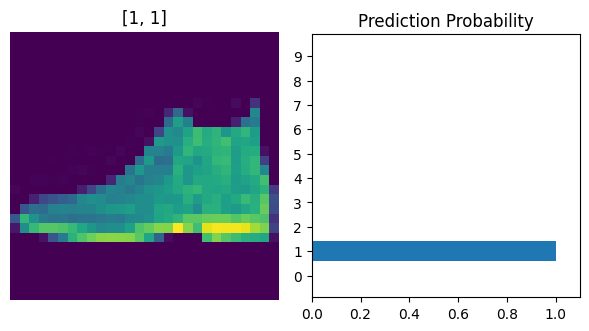

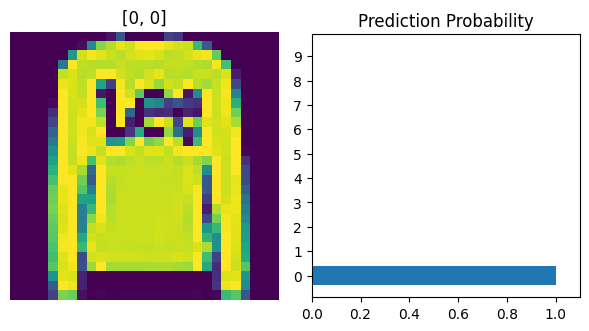

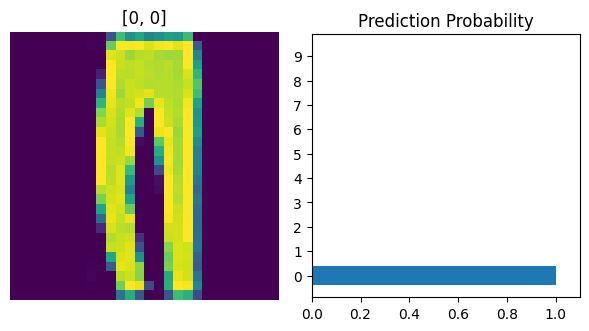

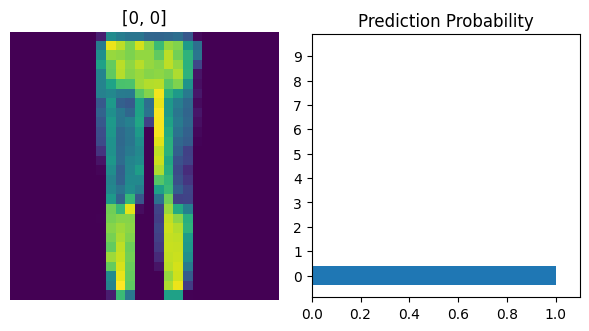

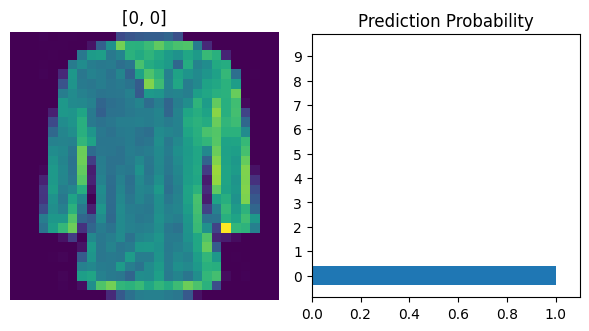

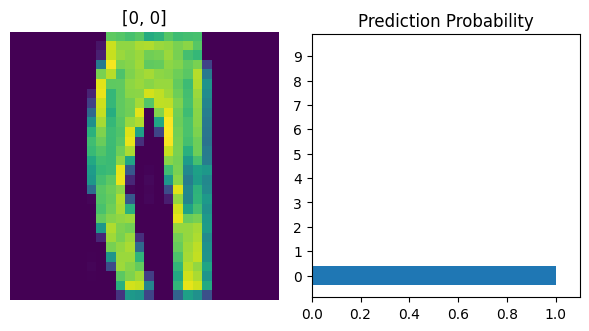

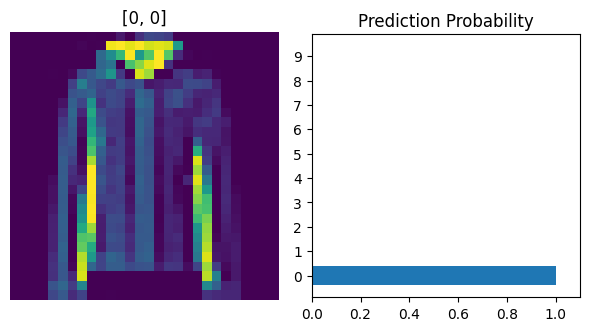

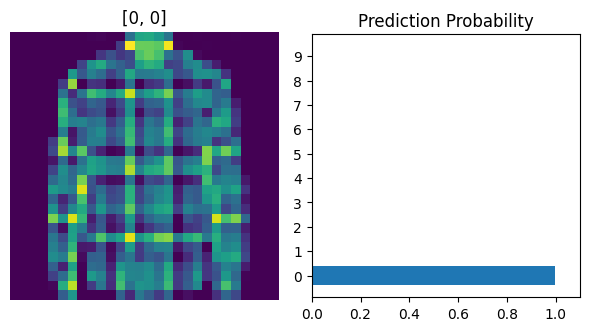

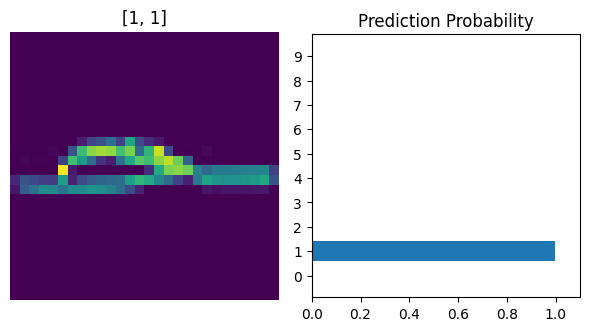

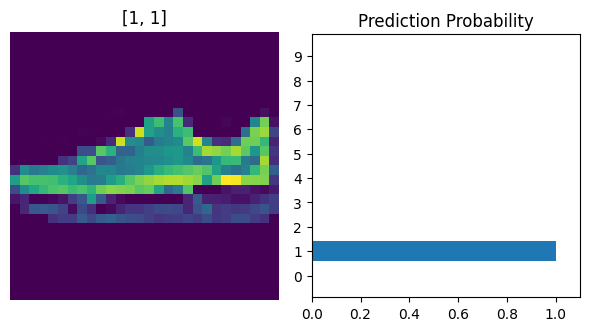

In [14]:
model_cnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)

for i in range(10):
    img = image_batch[i]
    
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    
    visualize_pred(img, pred_prob, real_label)

# Define the design of the CNN with `dropout`

In [34]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.do1 = nn.Dropout2d(p=0.8)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [40]:
print("Training on ", device)

model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)

print('Number of parameters: {}'.format(get_n_params(model_2)))

for epoch in range(0, 10):
    model_2.train()
    train(epoch, model_2)
    
    # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    model_2.eval()
    test(model_2)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306776
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.260941
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.087250
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.045286
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.193113
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.043274
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.133463
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.086054
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.140459
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.030835

Test set: Average loss: 0.0737, Accuracy: 9787/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.031855
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.038046
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.042139
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.301553
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.090624
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.092055
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.016325
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.040595
Tra

# Visualizate the results for the `dropout network`

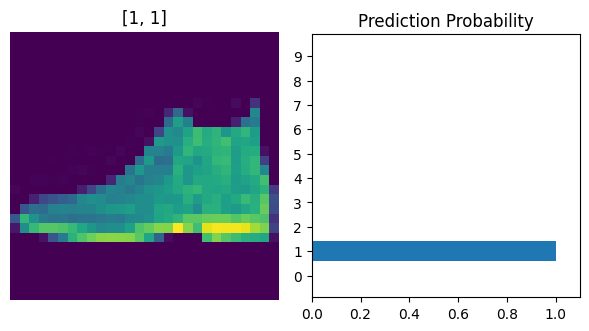

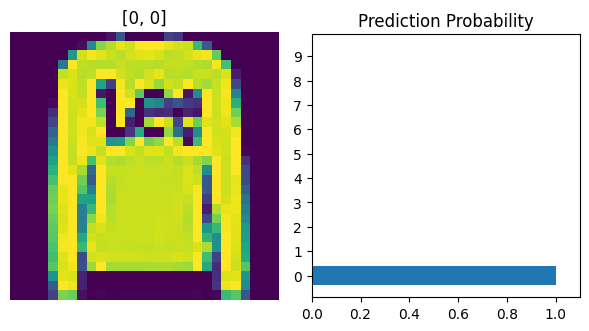

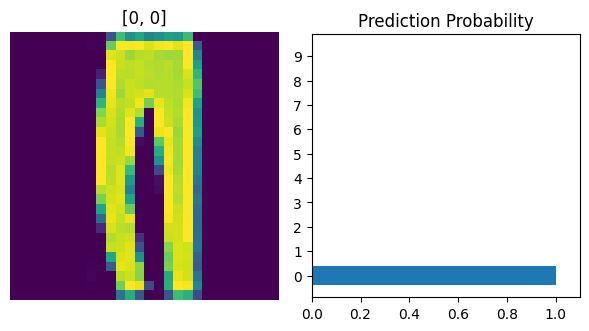

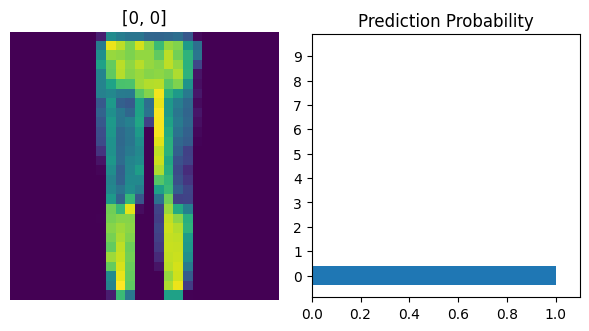

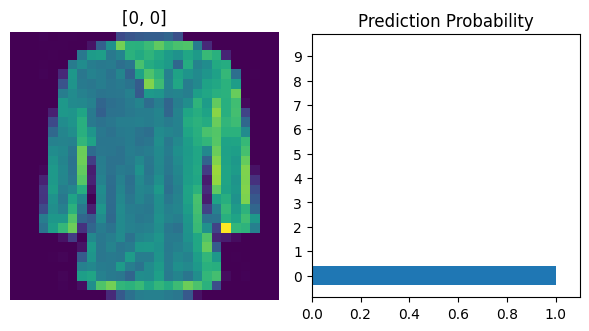

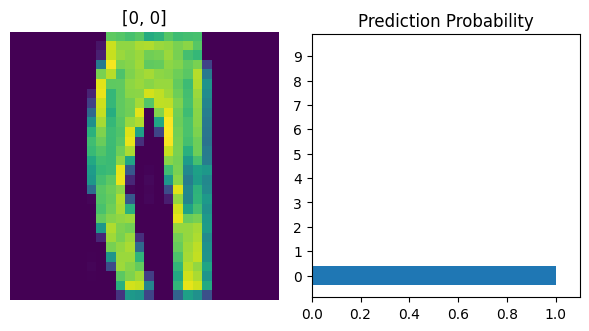

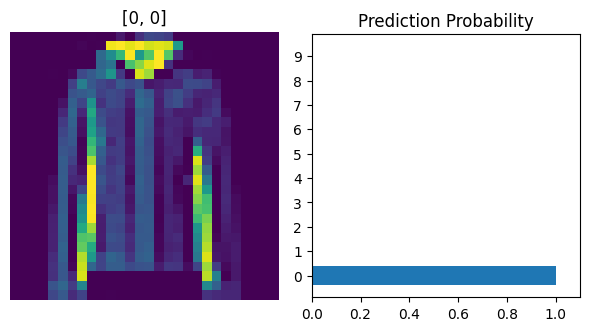

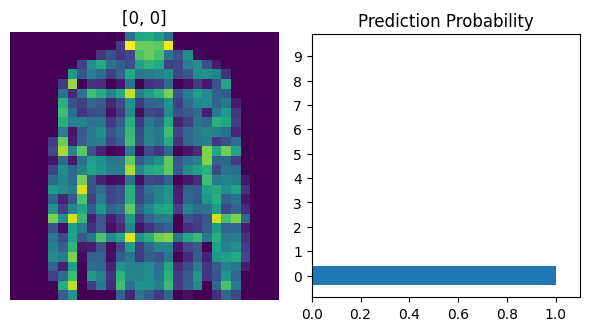

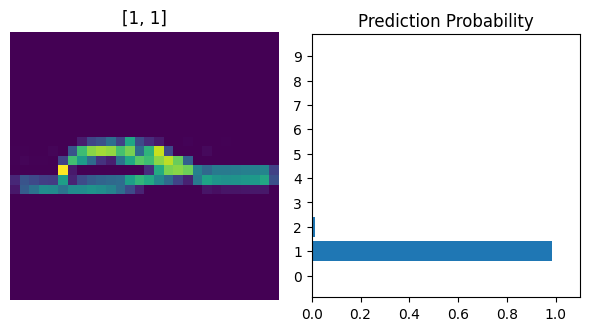

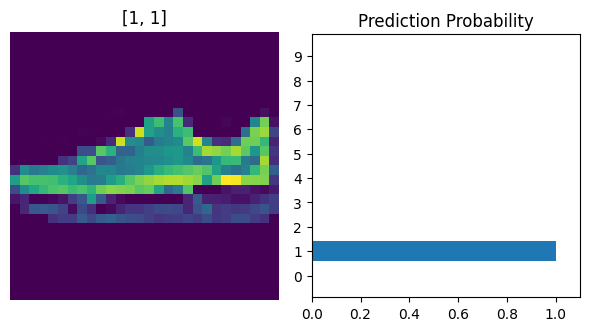

In [23]:
model_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_2(image_batch)

for i in range(10):
    img = image_batch[i]
    
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    
    visualize_pred(img, pred_prob, real_label)

# Does CNN use `Visual Information`?

We will perform the following test -
- We will scramble each image following a pre-defined permutation.
- CNN uses shapes, edges, lines to detect image informations
- If scrambled, the shapes will be changed, making it difficult for CNN to visulize
---
The test accuracy should be a little lower when scrambled.

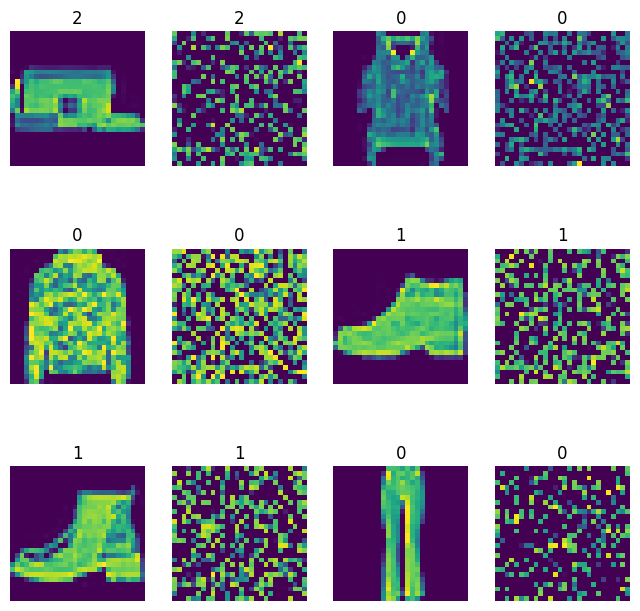

In [41]:
# Fix a permutation of the image pixels; We apply the same permutation to all images
fixed_perm = torch.randperm(784)

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)


# Function to scramble before train and test

In [42]:
def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    """Scramble the training set following the fixed permutation and train it"""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def scramble_test(model, perm=torch.arange(0, 784).long()):
    """Scramble the test set following the same permutation and test results"""
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train and test using the scrambled permutation

In [43]:
print("Training on ", device)

model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)

print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308775
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.444503
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.973690
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.056421
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.894113
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.040567
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.916798
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.836141
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.616451
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.782650

Test set: Average loss: 0.6930, Accuracy: 8286/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.777266
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.694164
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.488650
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.371888
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.468613
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.333353
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.331379
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.259473
Tra

# Visualize the scrambled dataset

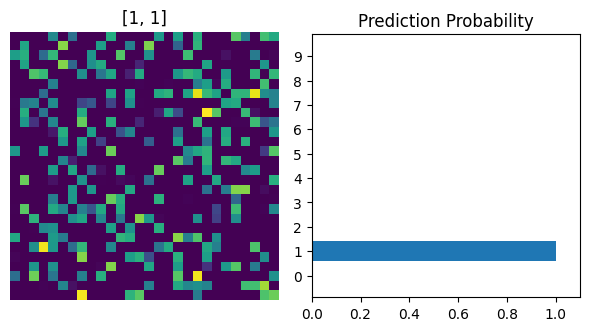

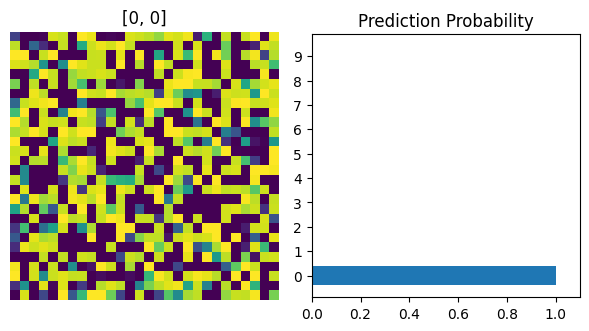

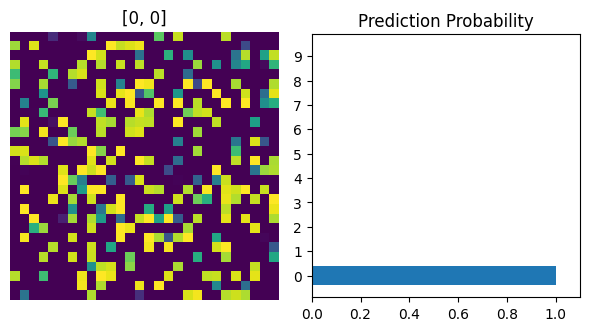

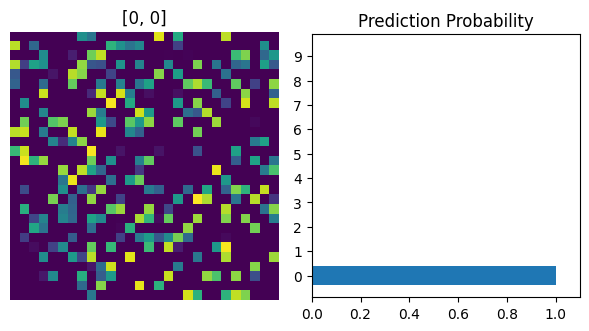

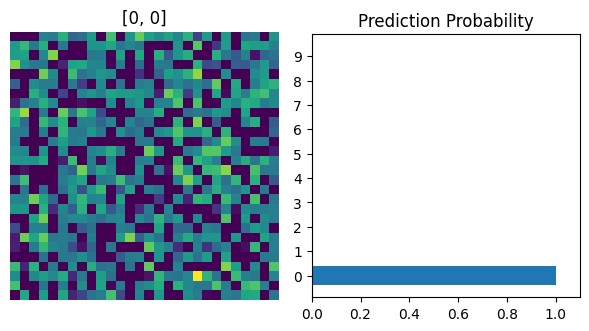

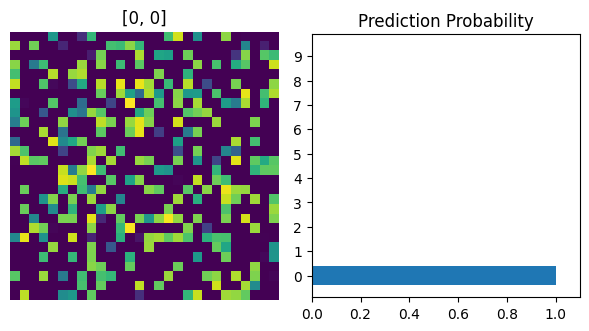

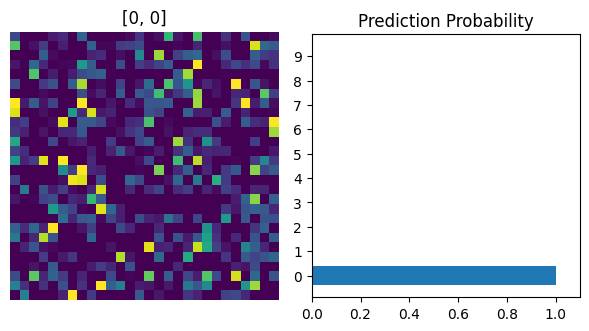

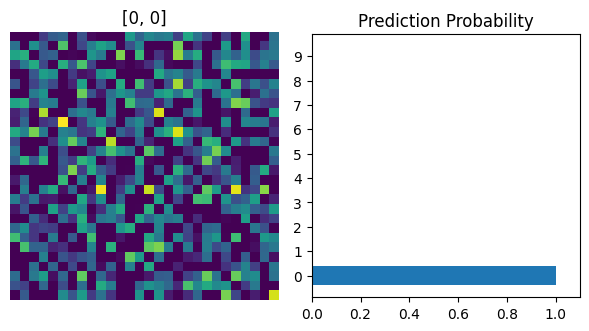

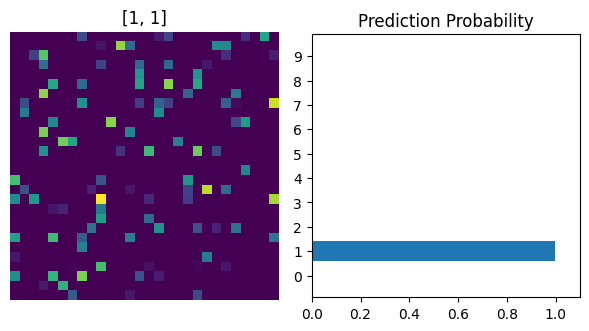

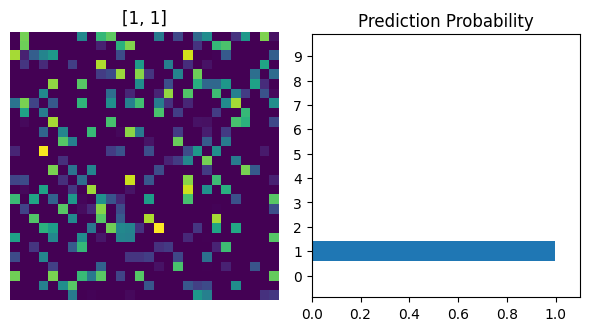

In [22]:
model_cnn_3.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)

for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    
    visualize_pred(img_perm, pred_prob, real_label)

# Conclusion:
As we can see, the `CNN` model and the `CNN Dropout` model worked incredibly well, but the `CNN Scrambled` model failed to achieve high accuracy.

---

| Model             | Description                                           | Accuracy | Observations                                                 |
|-------------------|-------------------------------------------------------|----------|--------------------------------------------------------------|
| CNN Model         | Basic CNN model trained on the original dataset        | 99.30%      | Achieved high accuracy within only 10 epochs. Performs well on FashionMNIST dataset. |
| CNN Dropout Model | CNN model with dropout layers to prevent overfitting   | 99.27%      | Excellent performance with high accuracy within only 10 epochs, prevents overfitting too.|
| CNN Scrambled Model | CNN model trained on a scrambled dataset              | 98.16%      | Poor performance, failed to learn meaningful patterns like edges, lines and shapes. |

---

So, we can conclude that:

***CNN does use visual information.***